# Experiment 6 - Train models using the VGG16 convolutional layers as feature extractor, pre-trained in ImageNet

In this experiment we train a VGG16-based model to perform classification using the Chest X-Ray dataset from Kaggle (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). But this time freezing all the convolutional layers from the VGG16 pre-trained using the ImageNet dataset.

We'll perform the same steps as before to find the best performance as possible using this architecture and training only the fully-connected layers from zero.

The results obtained here will be used later to compare with the results after fine-tuning some convolutional layers.

In [ ]:
%tensorflow_version 1.x
import os
import numpy as np
import tensorflow as tf
import random as rn
import keras
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from os import walk
from tqdm import *
from random import shuffle
from keras.utils import to_categorical
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Reshape, Conv2D, Dropout, Activation, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Set some variables to allow reproducibility

In [2]:
os.environ["PYTHONHASHSEED"] = "0"
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)
# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

## Download the flowers dataset from kaggle

### Set kaggle username and key

In [ ]:
os.environ["KAGGLE_USERNAME"] = "{username}"
os.environ["KAGGLE_KEY"] = "{key}"

### Download using the Kaggle API

https://www.kaggle.com/docs/api

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip
!rm -rf chest_xray/__MACOSX/
!rm -rf chest_xray/chest_xray/

## Organize data and split into train, validation and test

In [ ]:
dataset_path = 'chest_xray'
for dset in ['train','val','test']:
    print('-----------------------')
    print('Set:', dset)
    set_path = os.path.join(dataset_path, dset)
    print(set_path)

    for (dirpath, dirnames, filenames) in walk(set_path):
        if (len(dirnames) > 0):
            folders_with_labels = np.empty([len(dirnames), 3], dtype=object)
            i = 0
            for dir_name in sorted(dirnames, key=str.lower):
                folders_with_labels[i][0] = dir_name
                folders_with_labels[i][1] = i
                folders_with_labels[i][2] = []
                i += 1
    print(folders_with_labels)

    # Fill image paths in the array from images in the folders
    for path, label, imgs in folders_with_labels:
        for (dirpath, dirnames, filenames) in walk(os.path.join(set_path, path)):
            for file_name in filenames:
                imgs.append('{}/{}/{},{}'.format(dset, path, file_name, label))

    print('')
    print("Total images per class...")
    total = 0
    for path, label, imgs in folders_with_labels:
        print(path, ":", len(imgs))
        total += len(imgs)
    print('')
    print('Total of images:', total)

    all_imgs = []
    for path, label, imgs in folders_with_labels:
        all_imgs.extend(imgs)
    print('images:', len(all_imgs))

    shuffle(all_imgs)

    with open(os.path.join(dataset_path, '{}.txt'.format(dset)), 'w') as f:  
        f.writelines("%s\n" % item for item in all_imgs)

-----------------------
Set: train
chest_xray/train
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 1341
PNEUMONIA : 3875

Total of images: 5216
images: 5216
-----------------------
Set: val
chest_xray/val
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 8
PNEUMONIA : 8

Total of images: 16
images: 16
-----------------------
Set: test
chest_xray/test
[['NORMAL' 0 list([])]
 ['PNEUMONIA' 1 list([])]]

Total images per class...
NORMAL : 234
PNEUMONIA : 390

Total of images: 624
images: 624


## 1 - Training VGG16 as feature extractor with 2 FC layers

### Set initial parameters, functions and generators

Set parameters for our model and training

In [3]:
dataset_path = 'chest_xray'
width = 224
height = 224
input_shape = (width, height, 3)
batch_size = 10
verbose = 1
classes_dict = {
    0: 'NORMAL',
    1: 'PNEUMONIA'
}

Here we define 3 functions:


*   read_training_file() : Read the paths to images and labels for the dataset using each file (train, validation and test).
*   preprocess_image() : Preprocess the images in batch, set the size, the type and put in the TF format (scale pixels between -1 and 1).
*   data_generator() : Returns a generator that reads the images in batch and call the preprocess function, to be used in the training process with the fit_generator function.



In [4]:
def read_training_file(path, separator=' '):
    images = []
    labels = []
    with open(path, 'r') as f:
        for i in tqdm(f.readlines()):
            img_name, cls = i.strip().split(separator)
            cls = int(cls)
            images.append(img_name)
            labels.append(cls)
    return images, labels

def preprocess_image(images, images_path, width, height):
    pp_images = []

    for image in images:
        img = cv2.imread(os.path.join(images_path, image))
        if img.shape[0] != 224 or img.shape[1] != 224:
            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
        img = np.asarray(img, 'float32')
        img = preprocess_input(img, mode='tf')
        pp_images.append(img)

    return np.asarray(pp_images)

def data_generator(images, labels, batch_size, images_path, width, height):
    batch_start = 0
    while batch_start < len(images):
        batch_end = min(batch_start + batch_size, len(images))
        y_batch = labels[batch_start : batch_end]
        x_batch = preprocess_image(images[batch_start : batch_end],
                                   images_path,
                                   width,
                                   height)
        batch_start += batch_size
        if batch_start >= len(images):
            batch_start = 0
        yield (x_batch, y_batch)

Read the label files (train, val and test) and set two arrays:

1.   paths to images.
2.   labels as a binary class matrix, for use with categorical_crossentropy.



In [5]:
train_path = os.path.join(dataset_path, 'train.txt')
val_path = os.path.join(dataset_path, 'val.txt')
test_path = os.path.join(dataset_path, 'test.txt')

train_images, train_labels = read_training_file(train_path, ',')
val_images, val_labels = read_training_file(val_path, ',')
test_images, test_labels = read_training_file(test_path, ',')

print('Train: {} documents'.format(len(train_images)))
print('Validation: {} documents'.format(len(val_images)))
print('Test: {} documents'.format(len(test_images)))

# train_labels_one_hot = to_categorical(train_labels)
# val_labels_one_hot = to_categorical(val_labels)
# test_labels_one_hot = to_categorical(test_labels)
# print(train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape)

100%|██████████| 624/624 [00:00<00:00, 350461.39it/s]

Train: 5216 documents
Validation: 16 documents
Test: 624 documents


Create generators for the training set and validation set.

In [6]:
train_gen = data_generator(train_images, train_labels, batch_size, dataset_path, width, height)
val_gen = data_generator(val_images, val_labels, batch_size, dataset_path, width, height)

num_batches_per_epoch = int(round(len(train_images) / float(batch_size)))
num_batches_per_epoch_val = int(round(len(val_images) / float(batch_size)))

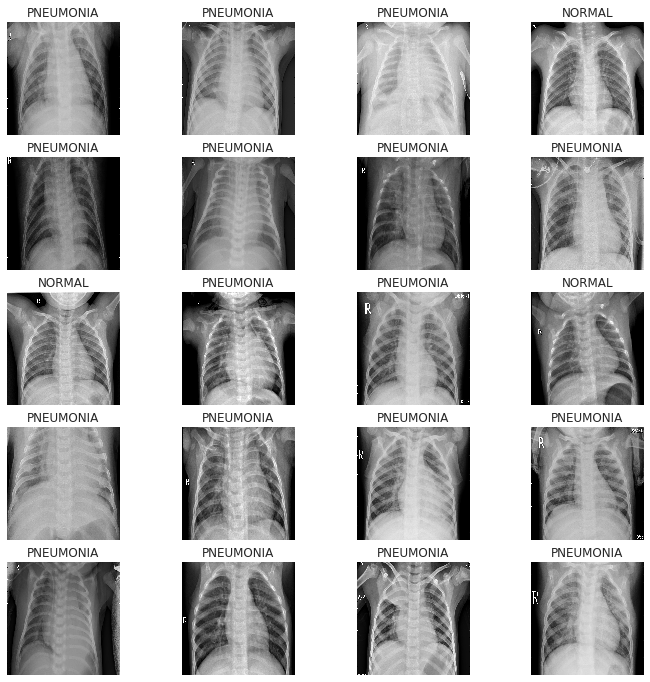

In [7]:
w=10
h=10
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1,21):
  sample = next(train_gen)
  img = cv2.cvtColor((sample[0][0]+1)/2, cv2.COLOR_BGR2RGB)
  label = classes_dict[sample[1][0]]
#   img = PIL.Image.open(os.path.join(dataset_path, train_images[i]))
#   label = classes_dict[train_labels[i]]
  fig.add_subplot(rows, columns, i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img)
plt.show()

### Define and compile the model architecture

In [11]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Freeze VGG layers

In [12]:
print('Not trainable')
for layer in model.layers[:20]:
    print(layer)
    layer.trainable = False
print('')
print('Trainable')
for layer in model.layers[20:]:
    print(layer)
    layer.trainable = True

Not trainable

Trainable


Compile the model after setting trainable layers, with the selected optimizer

In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 20

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [15]:
model.save('6_vgg16_feature_extraction_model1.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

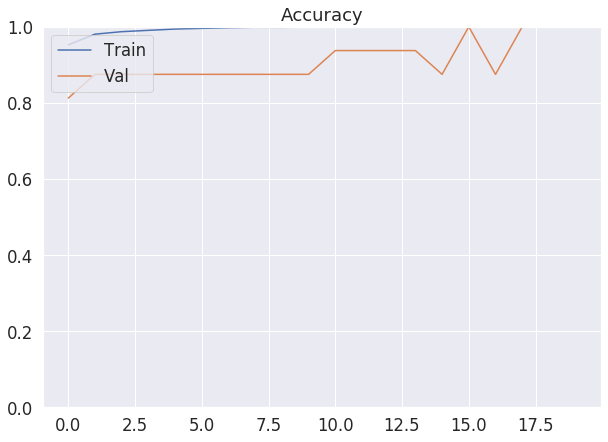

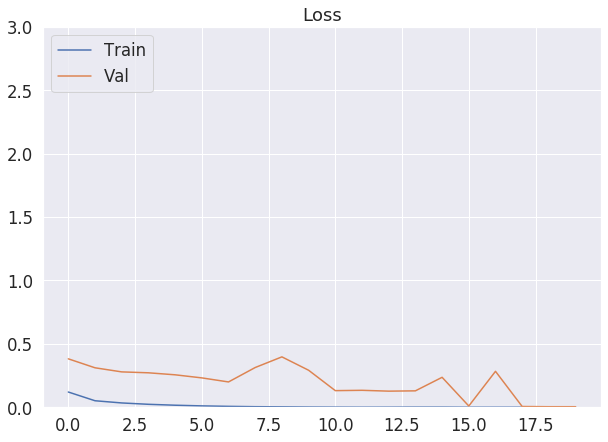

In [16]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

## 2 - Training VGG16 as feature extractor with 2 FC layers + Regularization

### Define and compile the model architecture

In [18]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Freeze VGG layers

In [19]:
print('Not trainable')
for layer in model.layers[:20]:
    print(layer)
    layer.trainable = False
print('')
print('Trainable')
for layer in model.layers[20:]:
    print(layer)
    layer.trainable = True

Not trainable

Trainable


In [20]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 20

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [22]:
model.save('6_vgg16_feature_extraction_model2.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

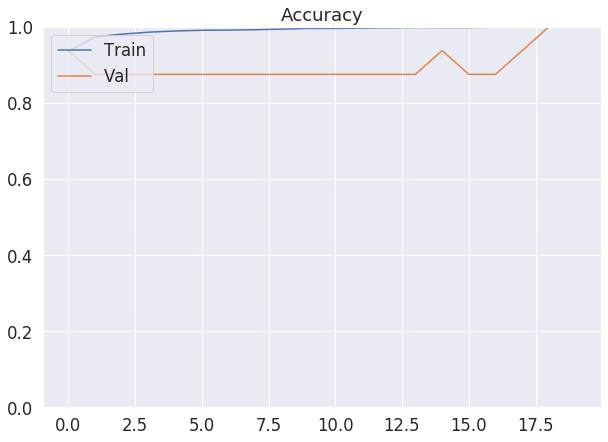

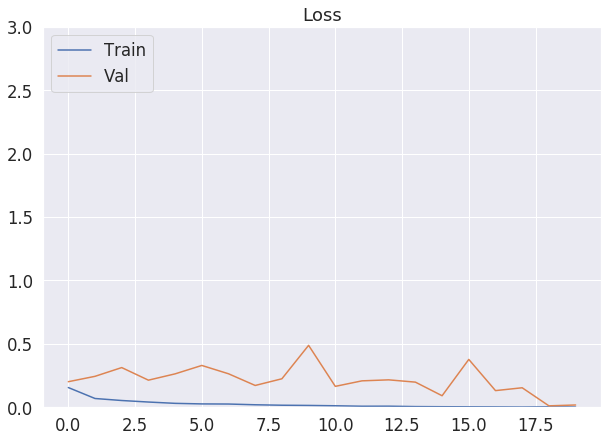

In [23]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)

## 3 - Training VGG16 as feature extractor with 2 FC layers + Regularization + Augmentation

### Create augmentation generator

Here we use the ImageDataGenerator from Keras to apply different types of augmentation.

In [25]:
image_gen = ImageDataGenerator(zoom_range=0.3,
                               horizontal_flip=True,
                               fill_mode='nearest')

In [26]:
def augmentation_generator(in_generator):

    for in_x, in_y in in_generator:
        g_x = image_gen.flow(in_x, in_y,
                             batch_size=in_x.shape[0])
        x, y = next(g_x)

        yield x, y

In [27]:
train_gen = augmentation_generator(train_gen)
val_gen = augmentation_generator(val_gen)

### Define and compile the model architecture

In [28]:
base_vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

x = base_vgg.output
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(inputs=base_vgg.input, outputs=x)

### Freeze VGG layers

In [29]:
print('Not trainable')
for layer in model.layers[:20]:
    print(layer)
    layer.trainable = False
print('')
print('Trainable')
for layer in model.layers[20:]:
    print(layer)
    layer.trainable = True

Not trainable

Trainable


In [30]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

### Train the model.

In [ ]:
num_epochs = 30

print('Start training...')
history = model.fit_generator(train_gen,
                                  steps_per_epoch=num_batches_per_epoch,
                                  epochs=num_epochs,
                                  verbose=verbose,
                                  validation_data=val_gen,
                                  validation_steps=num_batches_per_epoch_val)
print('Model trained.')

In [32]:
model.save('6_vgg16_feature_extraction_model3.h5')
print('Model saved.')

Model saved.


### Plot training metrics 

Plot accuracy and loss for the training and validation sets.

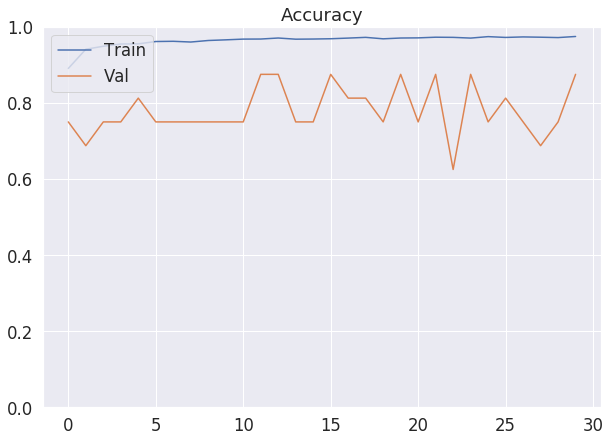

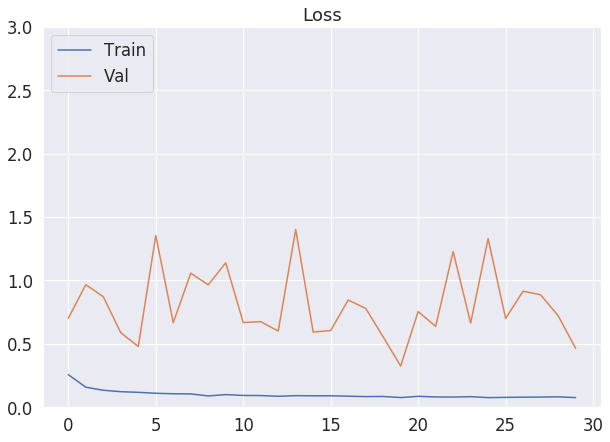

In [33]:
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Accuracy')
plt.ylim((0.0, 1.0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Val'], loc='upper left')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 7))
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0.0, 3.0))
plt.legend(['Train', 'Val'], loc='upper left')

### Evaluate the trained model with the test set.

In [ ]:
num_batches_per_epoch_test = int(round(len(test_images) / float(batch_size)))

print('Evaluating trained model...')
result = model.evaluate_generator(generator=data_generator(test_images,
                                                               test_labels,
                                                               batch_size,
                                                               dataset_path, width, height),
                                      steps=num_batches_per_epoch_test)

print("Finished model.evaluate_generator")
print(model.metrics_names)
print(result)